<a href="https://colab.research.google.com/github/Abdulkadir2516/spam_filter/blob/main/Spam_Filtresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls
%cd drive/MyDrive/yapilan_projeler/Spam_Filter/
!ls

drive  sample_data
/content/drive/MyDrive/yapilan_projeler/Spam_Filter
 Dataset  'Spam Filtresi.ipynb'


In [50]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import snowballstemmer as sn
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB




In [ ]:
df = pd.read_excel("Dataset/trspam.xlsx", engine="openpyxl")
df.head()

0.0 0.0.1  Unnamed: 2
0  SayÄ±n Yetkili ;\n  GeliÅŸen ve deÄŸiÅŸen gÃ¼nÃ¼mÃ¼z ...  spam         NaN
1  SayÄ±n Yetkili,\n \n28 KasÄ±m 2010 tarihli KPSS ...  spam         NaN
2  SayÄ±n Yetkili ;\n  GeliÅŸen ve deÄŸiÅŸen gÃ¼nÃ¼mÃ¼z ...  spam         NaN
3  T.C.\nURLA KAYMAKAMLIÄžI\nURLA HAKAN Ã‡EKEN ANAD...  spam         NaN
4  SayÄ±n Yetkili ;HÄ±zla bÃ¼yÃ¼yen ve geliÅŸmekte ola...  spam         NaN

In [ ]:
df.rename(columns={'0.0': 'ham_veri', '0.0.1': 'labels'}, inplace=True)
df.drop(['Unnamed: 2'], axis=1, inplace=True)
df.head()



ham_veri labels
0  SayÄ±n Yetkili ;\n  GeliÅŸen ve deÄŸiÅŸen gÃ¼nÃ¼mÃ¼z ...   spam
1  SayÄ±n Yetkili,\n \n28 KasÄ±m 2010 tarihli KPSS ...   spam
2  SayÄ±n Yetkili ;\n  GeliÅŸen ve deÄŸiÅŸen gÃ¼nÃ¼mÃ¼z ...   spam
3  T.C.\nURLA KAYMAKAMLIÄžI\nURLA HAKAN Ã‡EKEN ANAD...   spam
4  SayÄ±n Yetkili ;HÄ±zla bÃ¼yÃ¼yen ve geliÅŸmekte ola...   spam

#Ã–n iÅŸleme

In [17]:
stop_word = "acaba altmÄ±ÅŸ altÄ± ama ancak arada aslÄ±nda ayrÄ±ca az bana bazÄ± belki ben benden beni benim beri beÅŸ bile bin bir birÃ§ok biri birkaÃ§ birkez birÅŸey birÅŸeyi biz bize bizden bizi bizim bÃ¶yle bÃ¶ylece bu buna bunda bundan bunlar bunlarÄ± bunlarÄ±n bunu bunun burada Ã§ok Ã§Ã¼nkÃ¼ da daha dahi de defa deÄŸil diÄŸer diye doksan dokuz dolayÄ± dolayÄ±sÄ±yla dÃ¶rt edecek eden ederek edilecek ediliyor edilmesi ediyor eÄŸer elli en etmesi etti ettiÄŸi ettiÄŸini gibi gÃ¶re halen hangi hatta hem henÃ¼z hep hepsi her herhangi herkesin hiÃ§ hiÃ§bir iÃ§in iki ile ilgili ise iÅŸte itibaren itibariyle kadar karÅŸÄ±n katrilyon kendi kendilerine kendini kendisi kendisine kendisini kez ki kim kimden kime kimi kimse kÄ±rk milyar milyon mu mÃ¼ mÄ± nasÄ±l ne neden nedenle nerde nerede nereye niye niÃ§in o olan olarak oldu olduÄŸu olduÄŸunu olduklarÄ±nÄ± olmadÄ± olmadÄ±ÄŸÄ± olmak olmasÄ± olmayan olmaz olsa olsun olup olur olursa oluyor on ona ondan onlar onlardan onlarÄ± onlarÄ±n onu onun otuz oysa Ã¶yle pek raÄŸmen sadece sanki sekiz seksen sen senden seni senin siz sizden sizi sizin ÅŸey ÅŸeyden ÅŸeyi ÅŸeyler ÅŸÃ¶yle ÅŸu ÅŸuna ÅŸunda ÅŸundan ÅŸunlarÄ± ÅŸunu tarafÄ±ndan trilyon tÃ¼m Ã¼Ã§ Ã¼zerine var vardÄ± ve veya ya yani yapacak yapÄ±lan yapÄ±lmasÄ± yapÄ±yor yapmak yaptÄ± yaptÄ±ÄŸÄ± yaptÄ±ÄŸÄ±nÄ± yaptÄ±klarÄ± yedi yerine yetmiÅŸ yine yirmi yoksa yÃ¼z zaten"
stop_word = stop_word.split()


def stem_word(value):
    stemmer = sn.stemmer("turkish")
    value = value.lower()
    value = stemmer.stemWords(value.split())
    stop_words = stop_word

    value = [item for item in value if not item in stop_words]
    value = ' '.join(value)
    return value

def remove_single_chracter(value):
    return re.sub(r'(?:^| )\w(?:$| )','',value)

#sayÄ±lar ve noktalama iÅŸaretleri
def numeric_noktalama_remove(metin):
    temiz_metin = re.sub(r'[^\w\s]', '', metin)
    temiz_metin = re.sub(r'\d+', '', temiz_metin)
    return temiz_metin

def remove_link(value):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',value)

def remove_emoji(value):
    bfr = re.compile("[\U00010000-\U0010ffff]",flags=re.UNICODE)
    bfr = bfr.sub(r'',value)
    return bfr

In [18]:
df.ham_veri = df.ham_veri.astype(str).apply(numeric_noktalama_remove)
df.ham_veri = df.ham_veri.apply(stem_word)
df.ham_veri = df.ham_veri.apply(remove_single_chracter)
df.ham_veri = df.ham_veri.apply(remove_link)
df.ham_veri = df.ham_veri.apply(remove_emoji)
df.head()

ham_veri labels
0  say yetkil geliÅŸ deÄŸiÅŸ gÃ¼n teknolojis Ã§alÄ±ÅŸma ...   spam
1  say yetkil kas tarihli kpss sÄ±nav sonuÃ§ il yap...   spam
2  say yetkil geliÅŸ deÄŸiÅŸ gÃ¼n teknolojis Ã§alÄ±ÅŸma ...   spam
3  tc ur kaymakamlik ur hak Ã§ek anadol lises mÃ¼dÃ¼...   spam
4  say yetkil hÄ±z bÃ¼yÃ¼ geliÅŸmek ol topl bÃ¼ysaÄŸlay...   spam

In [19]:
df.ham_veri[0]

'say yetkil geliÅŸ deÄŸiÅŸ gÃ¼n teknolojis Ã§alÄ±ÅŸma koÅŸÄ±l Ã¶zellik kur Ã§alÄ±ÅŸ personel kur bÃ¼nye Ã§alÄ±ÅŸma koÅŸul ihtiyaÃ§ saÄŸlayabil Ã§alÄ±ÅŸ departma hÄ±zlÄ± ÅŸekilsaÄŸla motiv olabil baÅŸka departma geÃ§ za oryantasyo adaptasyo sÃ¼reÃ§ baÅŸar atlatanyÃ¼k ver saÄŸla personel ara yadsÄ±namaz gerÃ§ek koÅŸul Ã§erÃ§ev bÃ¼ro yÃ¶net sekreterlik mez al eÄŸit netiÃ§ santral memurluk gel evrak gi evrak kayÄ±t sistematik memur sekreterlik eÄŸit al Ã¶ncelik deva etmes gerekir arÅŸiv yÃ¶nte kullanÄ±lmas bÃ¼ro kullanÄ±l fotokopifaxvp ofis cihaz kullanÄ±lmas parmak klavye kulla temel bilgisayar eÄŸit offiÃ§ progra kullanÄ±lmas temel iktisat istatis kavra yÃ¶netiÃ§ asistanlÄ±k santral operatÃ¶rlÃ¼k eÄŸit alarak baÅŸar mez ol kiÅŸ kur ihtiyacÄ±o personel seÃ§ yÃ¶netiÃ§ asistanlÄ±k santral memurluk vhki bilgisayar iÅŸletmenlik bÃ¼ro memur pozisyo tercih mezuniyet branÅŸÄ± bÃ¼ro yÃ¶net sekreterlik olmas hal kur ihtiyaÃ§ karÅŸÄ±la adaptasyo oryantasyo sÃ¼reÃ§ enkÄ±s sÃ¼r aÅŸacak yÃ¼k ver alaca

In [26]:
df = df.dropna()
df.tail()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ham_veri  825 non-null    object
 1   labels    825 non-null    object
dtypes: object(2)
memory usage: 19.3+ KB


In [28]:
df.groupby("labels").size()

labels
ham     496
spam    329
dtype: int64

In [30]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)

In [34]:
len(msg_train),len(msg_test),len(label_train),len(label_test)

(660, 165, 660, 165)

svm accuracy score: 0.9575757575757575
svm accuracy score: 0.9570858817942594


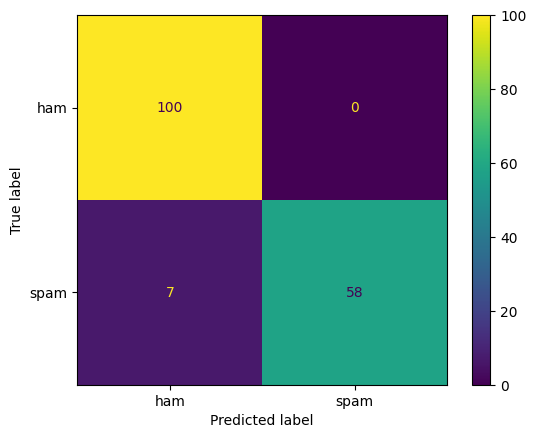

In [47]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)
svm = Pipeline([("vect",TfidfVectorizer()),('svm',LinearSVC())])

svm.fit(msg_train,label_train)
y_pred_class = svm.predict(msg_test)

print("svm accuracy score:", accuracy_score(label_test,y_pred_class))
print("svm accuracy score:", f1_score(label_test,y_pred_class,average="weighted"))

cm = confusion_matrix(label_test,y_pred_class, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()

knn accuracy score: 0.9272727272727272
knn accuracy score: 0.9272727272727272


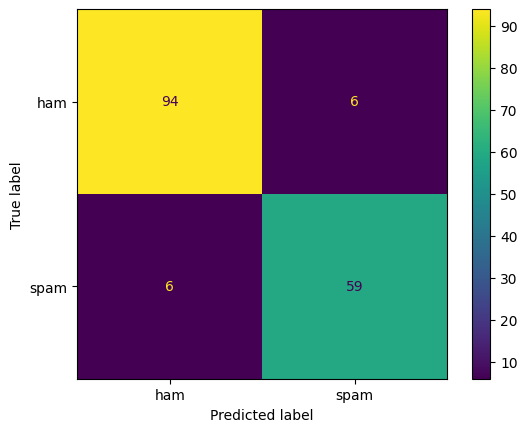

In [51]:
msg_train, msg_test, label_train, label_test = train_test_split(df.ham_veri.tolist(), df["labels"].tolist(), test_size=0.2, random_state=42)
knn = Pipeline([("vect",TfidfVectorizer()),('knn',KNeighborsClassifier())])
knn.fit(msg_train,label_train)
y_pred_class = knn.predict(msg_test)

print("knn accuracy score:", accuracy_score(label_test,y_pred_class))
print("knn accuracy score:", f1_score(label_test,y_pred_class,average="weighted"))

cm = confusion_matrix(label_test, y_pred_class, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

Naive Bayes accuracy score: 0.9151515151515152
Naive Bayes f1 score: 0.9136363636363637


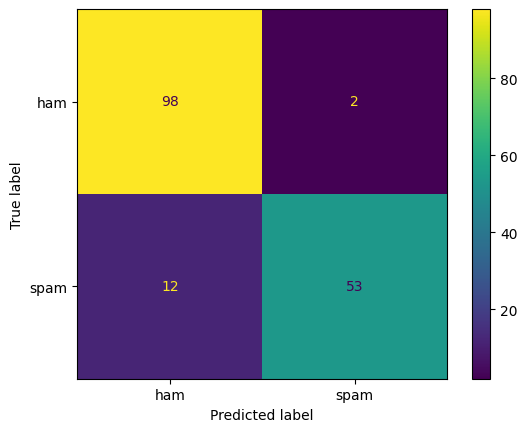

In [52]:
nb = Pipeline([("vect", TfidfVectorizer()), ('nb', MultinomialNB())])
nb.fit(msg_train, label_train)
y_pred_class = nb.predict(msg_test)

print("Naive Bayes accuracy score:", accuracy_score(label_test, y_pred_class))
print("Naive Bayes f1 score:", f1_score(label_test, y_pred_class, average="weighted"))

cm = confusion_matrix(label_test, y_pred_class, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

In [54]:
# prompt: test etmek istiyorum birilen metinden

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import snowballstemmer as sn
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Example usage of the trained models
test_message = "Windows cihazÄ±nda Google HesabÄ±nÄ±zda yeni bir oturum aÃ§ma iÅŸlemi tespit ettik. Bu iÅŸlem size aitse herhangi bir ÅŸey yapmanÄ±z gerekmez. Ä°ÅŸlem size ait deÄŸilse hesabÄ±nÄ±zÄ± gÃ¼ven altÄ±na almanÄ±za yardÄ±mcÄ± oluruz" # Example spam message
test_message2 = "ðŸ”¥AnÄ±nda %20-%30-%40-%50 indirimðŸ”¥Her tarza uygun ve birÃ§ok renk seÃ§eneÄŸiyle Denim Koleksiyonu'nu yÄ±l sonu fÄ±rsatlarÄ±yla keÅŸfet!ðŸ‘‡" # Example ham message


# Preprocess the test message using the same functions
test_message = numeric_noktalama_remove(test_message)
test_message = stem_word(test_message)
test_message = remove_single_chracter(test_message)
test_message = remove_link(test_message)
test_message = remove_emoji(test_message)

test_message2 = numeric_noktalama_remove(test_message2)
test_message2 = stem_word(test_message2)
test_message2 = remove_single_chracter(test_message2)
test_message2 = remove_link(test_message2)
test_message2 = remove_emoji(test_message2)

# Make predictions using SVM
svm_prediction = svm.predict([test_message])
print(f"SVM prediction for '{test_message}': {svm_prediction}")

svm_prediction = svm.predict([test_message2])
print(f"SVM prediction for '{test_message2}': {svm_prediction}")

# Make predictions using KNN
knn_prediction = knn.predict([test_message])
print(f"KNN prediction for '{test_message}': {knn_prediction}")

knn_prediction = knn.predict([test_message2])
print(f"KNN prediction for '{test_message2}': {knn_prediction}")

# Make predictions using Naive Bayes
nb_prediction = nb.predict([test_message])
print(f"Naive Bayes prediction for '{test_message}': {nb_prediction}")

nb_prediction = nb.predict([test_message2])
print(f"Naive Bayes prediction for '{test_message2}': {nb_prediction}")

SVM prediction for 'windows cihaz google hesap ye otur aÃ§ma iÅŸle tespit et iÅŸle ait yapma gerekmez iÌ‡ÅŸle ait hesap gÃ¼ve alt alma yardÄ±mcÄ±': ['ham']
SVM prediction for 'an indirimher tarza uygu renk seÃ§enek koleksiyon yÄ±l so fÄ±rsat keÅŸfet': ['ham']
KNN prediction for 'windows cihaz google hesap ye otur aÃ§ma iÅŸle tespit et iÅŸle ait yapma gerekmez iÌ‡ÅŸle ait hesap gÃ¼ve alt alma yardÄ±mcÄ±': ['ham']
KNN prediction for 'an indirimher tarza uygu renk seÃ§enek koleksiyon yÄ±l so fÄ±rsat keÅŸfet': ['ham']
Naive Bayes prediction for 'windows cihaz google hesap ye otur aÃ§ma iÅŸle tespit et iÅŸle ait yapma gerekmez iÌ‡ÅŸle ait hesap gÃ¼ve alt alma yardÄ±mcÄ±': ['ham']
Naive Bayes prediction for 'an indirimher tarza uygu renk seÃ§enek koleksiyon yÄ±l so fÄ±rsat keÅŸfet': ['ham']


In [ ]:
# prompt: bu modelleri kaydedelim baÅŸka yerde kullanÄ±caz

import joblib

# Save the trained models
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(nb, 'nb_model.pkl')

In [ ]:
# prompt: kaydedilen modelleri kullanalÄ±m bakalÄ±m

# Load the saved models
loaded_svm = joblib.load('svm_model.pkl')
loaded_knn = joblib.load('knn_model.pkl')
loaded_nb = joblib.load('nb_model.pkl')

# Example usage of the loaded models
test_message = "yeni bir mesaj Ã¶rneÄŸi"

# Preprocess the test message (using the same preprocessing steps as before)
test_message = numeric_noktalama_remove(test_message)
test_message = stem_word(test_message)
test_message = remove_single_chracter(test_message)
test_message = remove_link(test_message)
test_message = remove_emoji(test_message)

# Make predictions using the loaded models
svm_prediction = loaded_svm.predict([test_message])
print(f"SVM prediction for '{test_message}': {svm_prediction}")

knn_prediction = loaded_knn.predict([test_message])
print(f"KNN prediction for '{test_message}': {knn_prediction}")

nb_prediction = loaded_nb.predict([test_message])
print(f"Naive Bayes prediction for '{test_message}': {nb_prediction}")